# **Abstract**

BoomBikes, a U.S.-based bike-sharing service, has faced a significant drop in revenues due to the COVID-19 pandemic, which has led to a struggle for sustainability in the current market conditions. To counteract this, BoomBikes aims to develop a strategic plan to boost revenue as soon as lockdown restrictions are lifted and the economy stabilizes.

To prepare for post-pandemic conditions, BoomBikes wants to better understand the anticipated demand for shared bikes. By gaining insights into the needs of customers once normalcy returns, the company aims to position itself as a standout provider and achieve a competitive advantage over other service providers.

# **Problem Statement**

BoomBikes has engaged a consulting firm to identify the main factors influencing the demand for shared bikes in the U.S. market. The company wants to understand:

The significant variables that predict shared bike demand
How effectively these variables explain variations in bike demand
Using a dataset collected on daily bike usage across the U.S., BoomBikes intends to analyze the impact of various factors based on weather and consumer behavior.

# **Business Objective**

Our goal is to create a model that forecasts the demand for shared bikes, utilizing the available variables. This model will help management assess how demand responds to different factors, enabling the company to align its business strategy with expected demand levels and enhance customer satisfaction. Additionally, the model will provide valuable insights into demand patterns in a new market environment.

# **Proposed Solution Approach**

We will utilize multiple linear regression to address this problem, following these steps:

- Data Review and Initial Exploration
- Data Visualization
- Data Preparation
- Splitting Data into Training and Testing Sets
- Model Building
- Analyzing Residuals on Training Data
- Making Predictions with the Final Model
- Model Evaluation
- Conclusion

# **Assumptions**

As time is a key factor for the company’s future strategy, we will incorporate it into the analysis. The Plotly library will be used to create clean and interactive visualizations, including a range of exploratory plots.

In [155]:
pip install pingouin

In [156]:
# Data Reading, Wrangling, and processing Libs
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Plotting Libs

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot
import plotly.figure_factory as ff

# Modeling Libs
from sklearn.linear_model import LinearRegression

# Feature Selection
from sklearn.feature_selection import RFE, RFECV

# Statistical Libs
import pingouin as pg
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utility Libs
from IPython.display import display,Markdown
import calendar
from typing import Callable, Dict, Sequence, Tuple, Union
from enum import Enum, auto
import os
import warnings
from datetime import datetime, date

# **Global variables**

In [4]:
# columns
instant = 'instant'
dteday = 'dteday'
season = 'season'
yr = 'yr'
mnth = 'mnth'
holiday = 'holiday'
weekday = 'weekday'
workingday = 'workingday'
weathersit = 'weathersit'
temp = 'temp'
atemp = 'atemp'
hum = 'hum'
windspeed = 'windspeed'
casual = 'casual'
registered = 'registered'
cnt = 'cnt'
month = 'month'
date_of_month = 'date_of_month'
week_day = 'week_day'
week_day_name = 'week_day_name'
quarter = 'quarter'
week_of_year = "week_of_year"
numeric_columns = [temp, atemp, hum, windspeed, casual, registered, cnt]

col_name_map = {
    dteday: "Date On",
    season: "Season",
    yr: "Year",
    mnth: "Month Number",
    holiday: " Is holiday",
    weekday: "Weekday",
    workingday: "Is Working Day",
    weathersit: "Weather Type",
    temp: "Temperature in Celsius",
    atemp: "Feeling temperature in Celsius",
    hum: "Humidity in %",
    windspeed: "Wind Speed",
    casual: "Count of casual users",
    registered: "Count of registered users",
    cnt: "Total User Counts",
    month: "Month Of Year",
    date_of_month: "Date of Month",
    week_day: "Week Day",
    week_day_name: "Week day Name",
    quarter: "Quarter",
    week_of_year: "Week of the year"
}


seasons_map = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
weathersit_map = {
    1: "Clear, Few clouds, Partly cloudy, Partly cloudy",
    2: "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",
    3: "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds",
    4: "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog"
}
workingday_map = {1: "Working", 0: "Non Workind"}
#  Set name value mapping
month_name_map = {i: date(datetime.now().year, i, 1).strftime('%B')
                  for i in range(1, 13)}
holiday_map = {1: "Holiday", 0: "Non Holiday"}
# Listing from Tuesday because in this file Tuesday is considered as 0
days_of_week = ["Tuesday", "Wednesday", "Thursday",
                "Friday", "Saturday", "Sunday", "Monday"]
weekday_map = {i: days_of_week[i] for i in range(len(days_of_week))}
year_map = {0: 2018, 1: 2019}
date_of_month_map = {i: i for i in range(1, 32)}
quarter_map = {1: "First", 2: "Second", 3: "Third", 4: "Fourth"}
col_value_map = {
    workingday: workingday_map,
    month: month_name_map,
    mnth: month_name_map,
    holiday: holiday_map,
    week_day: weekday_map,
    weekday: weekday_map,
    yr: year_map,
    season: seasons_map,
    weathersit: weathersit_map,
    date_of_month: date_of_month_map,
    quarter: quarter_map
}

# **Utility Functions**

In [5]:
class GraphType(Enum):
    """Graph Type Enum

    Args:
        Enum ([type]): Built-in Enum Class
    """
    BAR = auto()
    LINE = auto()


def plot_univariate_series(
        series: pd.Series,
        title: str,
        xlabel: str,
        ylabel: str,
        graph_type: GraphType = None,
        **kwargs) -> None:
    """Bar plots a interger series

    Args:
        series (pd.Series): series to be plotted
        title (str): graph title
        xlabel (str): x-axis label
        ylabel (str): y-axis label
        display_format (str, optional): number format. Defaults to '{0:,.0f}'.
        figsize ([type], optional): figure size. Defaults to None.
        show_count (bool, optional): show value at the top of bar. Defaults to True.
        graph_type (GraphType, optional): graph type
    """
    labels = {"x": xlabel, "y": ylabel}
    fig = None
    if graph_type is None or graph_type == GraphType.BAR:
        fig = px.bar(x=series.index, y=series, color=series.index,
                     title=title, labels=labels, **kwargs)
    if graph_type == GraphType.LINE:
        px.scatter(x=series.index, y=series, title=title, labels=labels, color=series.index,
                   **kwargs)
    fig.show()


def get_univariate_cat_plot_strs(value: str) -> Tuple[str, str, str]:
    """Creates graph title, x-axis text and y-axis text for given value

    Args:
        value (str): column name

    Returns:
        Tuple[str, str, str]: title, x-axis text and y-axis text
    """
    title_case = value.replace('_', '').title()
    count_str = title_case + ' Count'
    return count_str + ' Plot', title_case, count_str


def plot_univariate_categorical_columns(categorical_cols: Sequence[str], dataframe: pd.DataFrame, **kwargs) -> None:
    """plots categorical variable bars

    Args:
        categorical_cols (Sequence[str]): categorical columns
        dataframe (pd.DataFrame): DataFrame
    """
    for c in categorical_cols:
        value_counts_ser = dataframe[c].value_counts().sort_index()
        cnt_len = len(value_counts_ser)
        if cnt_len < 16:
            t, xl, yl = get_univariate_cat_plot_strs(c)
            value_counts_ser.index = value_counts_ser.index.map(
                col_value_map[c])
            plot_univariate_series(value_counts_ser, t,
                                   xl, yl, **kwargs)

# **Step 1: Reading and Understanding the Data**

In [6]:
df = pd.read_csv("day.csv")

In [8]:
df.shape

(730, 16)

In [10]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,730.0,365.500000,210.877136,1.000000,183.250000,365.500000,547.750000,730.000000
season,730.0,2.498630,1.110184,1.000000,2.000000,3.000000,3.000000,4.000000
yr,730.0,0.500000,0.500343,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,730.0,6.526027,3.450215,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,730.0,0.028767,0.167266,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,730.0,2.997260,2.006161,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,730.0,0.683562,0.465405,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,730.0,1.394521,0.544807,1.000000,1.000000,1.000000,2.000000,3.000000
temp,730.0,20.319259,7.506729,2.424346,13.811885,20.465826,26.880615,35.328347
atemp,730.0,23.726322,8.150308,3.953480,16.889713,24.368225,30.445775,42.044800


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [14]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

## **Dropping Identity**

In [15]:
df.drop(instant, axis=1, inplace=True)

We can observe that

No Nulls in data
dteday should be date
season, yr, mnth, holiday,weekday, workingday, weathersit should be category
So we'll convert them correspondingly

In [16]:
# convert columns to category
cat_columns = [season, yr, mnth, holiday, weekday, workingday, weathersit]
df[cat_columns] = df[cat_columns].astype('category')
df.dtypes

,0
dteday,object
season,category
yr,category
mnth,category
holiday,category
weekday,category
workingday,category
weathersit,category
temp,float64
atemp,float64


In [17]:
# convert dteday as date
df[dteday] = pd.to_datetime(df[dteday], format='%d-%m-%Y')
df.dtypes

,0
dteday,datetime64[ns]
season,category
yr,category
mnth,category
holiday,category
weekday,category
workingday,category
weathersit,category
temp,float64
atemp,float64


Data types look good now

In [18]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
dteday,730,2018-12-31 12:00:00,2018-01-01 00:00:00,2018-07-02 06:00:00,2018-12-31 12:00:00,2019-07-01 18:00:00,2019-12-31 00:00:00,NaN
temp,730.0,20.319259,2.424346,13.811885,20.465826,26.880615,35.328347,7.506729
atemp,730.0,23.726322,3.95348,16.889713,24.368225,30.445775,42.0448,8.150308
hum,730.0,62.765175,0.0,52.0,62.625,72.989575,97.25,14.237589
windspeed,730.0,12.76362,1.500244,9.04165,12.125325,15.625589,34.000021,5.195841
casual,730.0,849.249315,2.0,316.25,717.0,1096.5,3410.0,686.479875
registered,730.0,3658.757534,20.0,2502.25,3664.5,4783.25,6946.0,1559.758728
cnt,730.0,4508.006849,22.0,3169.75,4548.5,5966.0,8714.0,1936.011647


# **EDA**

**Observation about target columns**

Here we can select casual, registered, and cnt as target variables separately for analysis
- Though we'll see their relationship
- For this analysis we'll consider cnt as target column

# **Step 2. Visualizing the Data**
**Uni Variate analysis**


In [19]:
cat_columns = df.select_dtypes(include='category').columns
plot_univariate_categorical_columns(cat_columns, df)

**Conclusions**:



1.   Seasons are almost equally distributed
2.   We have data for complete two years
3.   Data is present for all months and all days
4.   There were 21 days for holiday
5.   231 were non working and 499 working days
6.   Weathers:
   - 463 days were clear, Few clouds, Partly cloudy, Partly cloudy
   - 246 days were Mist + Cloudy, Mist + Broken clouds, Mist + Few  
     clouds,Mist
   - 21 days were Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
7.   Mostly weather was good



In [20]:
def plot_hist(df: pd.DataFrame, x: str, y: str, title: str, **kwargs):
    """Plot Histograms for given dataframe and selected columns

    Args:
        df (pd.DataFrame): Dataframe
        x (str): x-axis column
        y (str): y-axis column
        title (str): Title for graph
    """
    fig = px.histogram(
        df, x=x, y=y, title="Histogram for " + title.title(), **kwargs)
    fig.show()


def plot_area(df: pd.DataFrame, x: str, y: str, title: str, **kwargs):
    """Plot AreaGraph for given dataframe and selected columns

    Args:
        df (pd.DataFrame): Dataframe
        x (str): x-axis column
        y (str): y-axis column
        title (str): Title for graph
    """
    fig = px.area(df, x=x, y=y, title="Trend for " +
                  title.title(), line_shape="spline", **kwargs)
    fig.show()


def plot_box(df: pd.DataFrame, x: str, y: str, title: str, **kwargs):
    """Plot BoxPlot for given dataframe and selected columns

    Args:
        df (pd.DataFrame): Dataframe
        x (str): x-axis column
        y (str): y-axis column
        title (str): Title for graph
    """
    fig = px.box(df, x=x, y=y, title="Box and Whisker plot for " +
                 title.title(), **kwargs)
    fig.show()


def plot_numeric_col(df: pd.DataFrame, x: str, y: str, title: str, plotters: Callable[[pd.DataFrame, str, str, str, dict], None], **kwargs) -> None:
    """This is a higher order function, which plot selected(passed function refs in plotters variable) plots for given dataframe and selected columns

    Args:
        df (pd.DataFrame): Dataframe
        x (str): x-axis column
        y (str): y-axis column
        title (str): Title for graph
        plotters ([type]): plotting functions
    """
    if df is not None and x is not None and y is not None and title is not None and plotters is not None:
        for plt_fun in plotters:
            plt_fun(df, x, y, title, **kwargs)

In [21]:
numeric_col_names = [col_name_map.get(cn) for cn in numeric_columns]

In [22]:
def box_for_numerics() -> None:
    for col in numeric_columns:
        col_name = col_name_map.get(col)
        fig = px.box(df, y=col, title="Box and Whisker plot for " +
                     col_name.title(), labels={col: col_name})
        fig.show()

In [23]:
box_for_numerics()

**It is clear that 2019 has been better than 2018 for BoomBike**

Lets plot 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered' and 'cnt' plots against 'dteday'

In [24]:
def plot_numeric_columns_trends_for_data() -> None:
    for col in numeric_columns:
        col_name = col_name_map.get(col)
        plot_numeric_col(df, x=dteday, y=col, title=col_name,
                         plotters=[plot_hist, plot_area], labels={dteday: "Dates", col: col_name})

In [25]:
plot_numeric_columns_trends_for_data()

In [26]:
def numeric_values_box(df: pd.DataFrame, x_col_name: str) -> None:
    for col in numeric_columns:
        col_name = col_name_map.get(col)
        df_plot = df[[col, x_col_name]]
        df_plot[x_col_name] = df_plot[x_col_name].map(
            col_value_map.get(x_col_name))
        plot_numeric_col(df_plot, x=x_col_name, y=col, title=col_name,
                         plotters=[plot_box], labels={x_col_name: col_name_map.get(x_col_name), col: col_name}, color=x_col_name)

In [27]:
#  year wise change in numeric values
numeric_values_box(df, yr)

In [28]:
# month wise change in numeric values
numeric_values_box(df, mnth)

# **Date Break up features**

In [30]:
# Extract date parts
df[date_of_month] = df[dteday].dt.day
df[quarter] = df[dteday].dt.quarter
df[week_day_name] = df[dteday].dt.day_name()
df[week_day] = df[dteday].dt.dayofweek
df[week_of_year] = df[dteday].dt.isocalendar().week

In [31]:
# Day wise
numeric_values_box(df, date_of_month)

In [32]:
# Quarter wise
numeric_values_box(df, quarter)


In [33]:
# Week days wise
numeric_values_box(df, weekday)

# **Scatter plots**

In [34]:
def plot_scatter_col_vs_counts(data: pd.DataFrame, col: str, **kwargs) -> None:
    for cnt_col in [casual, registered, cnt]:
        plot_df = data[[col, cnt_col, yr]]
        plot_df[yr] = plot_df[yr].map(col_value_map.get(yr))
        fig = px.scatter(plot_df, x=col, y=cnt_col, color=yr, title="Scatter for " +
                         # size=cnt_col,
                         col_name_map.get(col) + " vs " + \
                         col_name_map.get(cnt_col),
                         labels={
                             yr: col_name_map.get(yr),
                             col: col_name_map.get(col),
                             cnt_col: col_name_map.get(cnt_col),
                         }, ** kwargs)
        fig.show()

In [35]:
plot_scatter_col_vs_counts(df, temp)

In [36]:
# User type Relationship

fig = px.line(df, x=dteday, y=[casual, registered, cnt], width=1200)
fig.show()


In [37]:
def plot_bike_usage_trends_vs_numeric_columns() -> None:
    for num_col in numeric_columns:
        fig = px.line(df, x=dteday, y=num_col, width=1200,
                      #   facet_col=dteday, facet_col_spacing=0.04,
                      labels={
                          num_col: col_name_map.get(num_col),
                          dteday: col_name_map.get(dteday),
                      }, title=f"{col_name_map.get(num_col)} Trend")
        fig.show()

In [38]:
plot_bike_usage_trends_vs_numeric_columns()

# **Bi-Variate Analysis**

Pair plot

In [39]:
# pair plot
fig = px.scatter_matrix(df[numeric_columns], width=1200, height=1200)
fig.show()

temp is having best relationship with usage, i. e. in worm weather peple are more tend to use bikes

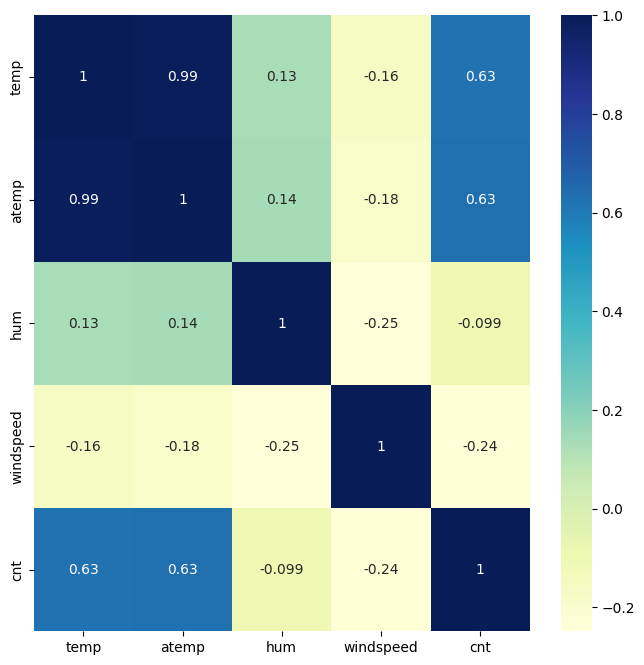

In [40]:
# Numeric column heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(df[[temp, atemp, hum, windspeed, cnt]].corr(),
            annot=True, cmap="YlGnBu")
plt.show()

Growth check for each count ie casual, registered and cnt

In [41]:
df_for_growth = df[[yr, casual, registered, cnt]].melt(
    id_vars=[yr], value_vars=[casual, registered, cnt])
plot_numeric_col(df_for_growth, x=yr, y='value', title='Bike use trend break up',
                 plotters=[plot_box], color='variable')


We can see that each component has growth

# **Multi Variate analysis**

In [52]:
from typing import Sequence
import pandas as pd

def pairwise_corr(df: pd.DataFrame, columns: Sequence[str], method: str = 'pearson') -> pd.DataFrame:
    return df[columns].corr(method=method)

In [78]:
pairwise_corr(df, columns=[temp, atemp, hum, windspeed, cnt], method='pearson')

,temp,atemp,hum,windspeed,cnt
temp,1.000000,0.991696,0.128565,-0.158186,0.627044
atemp,0.991696,1.000000,0.141512,-0.183876,0.630685
hum,0.128565,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.158186,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.627044,0.630685,-0.098543,-0.235132,1.000000


Here we can see that temp<=>atemp have very high correlation so lets drop one and see the changes

In [54]:
# Pairwise correlation without temp
pairwise_corr(df, columns=[atemp, hum,
                              windspeed, cnt], method='pearson')

,atemp,hum,windspeed,cnt
atemp,1.000000,0.141512,-0.183876,0.630685
hum,0.141512,1.000000,-0.248506,-0.098543
windspeed,-0.183876,-0.248506,1.000000,-0.235132
cnt,0.630685,-0.098543,-0.235132,1.000000


This looks good

In [57]:
pg.linear_regression(df[[temp, atemp, hum, windspeed]], df[cnt])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3855.504470,355.505714,10.845127,1.687372e-25,0.46296,0.459997,3157.560914,4553.448027
1,temp,50.910411,55.678826,0.914359,3.608325e-01,0.46296,0.459997,-58.400568,160.221390
2,atemp,103.136585,51.551810,2.000639,4.580369e-02,0.46296,0.459997,1.927934,204.345236
3,hum,-31.333136,3.845250,-8.148531,1.613211e-15,0.46296,0.459997,-38.882290,-23.783983
4,windspeed,-67.565586,10.764637,-6.276625,5.953644e-10,0.46296,0.459997,-88.699169,-46.432004


p value is very high for temp so lets drop and see the change

In [58]:
pg.linear_regression(df[[atemp, hum, windspeed]], df[cnt])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,3770.043964,342.960700,10.992641,4.159560e-26,0.46234,0.460119,3096.730849,4443.357078
1,atemp,149.884258,6.609957,22.675526,1.765126e-86,0.46234,0.460119,136.907345,162.861170
2,hum,-31.512556,3.839806,-8.206810,1.034167e-15,0.46234,0.460119,-39.051005,-23.974107
3,windspeed,-65.839328,10.596590,-6.213256,8.740830e-10,0.46234,0.460119,-86.642944,-45.035711


We see that all the variables looks good now

# **Step 3. Data Preparation**
Lets encode and include categorical columns as well

In [59]:
# Create Dummies function


def create_dummies(data_frame: pd.DataFrame) -> pd.DataFrame:
    clean_df = pd.DataFrame()
    cat_cols = list(data_frame.select_dtypes(include=['category']).columns)
    cat_cols = cat_cols + [date_of_month, quarter, week_day_name]
    for cat_col in cat_cols:
        dummies = pd.get_dummies(data_frame[cat_col], drop_first=True)
        dummies.columns = [cat_col + "_" +
                           str(i) for i in range(dummies.shape[1])]
        clean_df = pd.concat([clean_df, dummies], axis=1)

    return pd.concat([data_frame.drop(cat_cols, axis=1), clean_df], axis=1)

In [60]:
# Create Dummies
frame_with_dummies = create_dummies(df)
frame_with_dummies.columns

Index(['dteday', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered',
       'cnt', 'week_day', 'week_of_year', 'season_0', 'season_1', 'season_2',
       'yr_0', 'mnth_0', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'holiday_0',
       'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'workingday_0', 'weathersit_0', 'weathersit_1',
       'date_of_month_0', 'date_of_month_1', 'date_of_month_2',
       'date_of_month_3', 'date_of_month_4', 'date_of_month_5',
       'date_of_month_6', 'date_of_month_7', 'date_of_month_8',
       'date_of_month_9', 'date_of_month_10', 'date_of_month_11',
       'date_of_month_12', 'date_of_month_13', 'date_of_month_14',
       'date_of_month_15', 'date_of_month_16', 'date_of_month_17',
       'date_of_month_18', 'date_of_month_19', 'date_of_month_20',
       'date_of_month_21', 'date_of_month_22', 'date_of_month_23',
       'date_of_month_24', 'date


We'll drop below columns:

- dteday : We have plotted necessary graphs and extrated required information
- temp : Highly correlated with a temperature
- casual & registered : cnt is sum of both and we are concentrating on total use in this study
- week_of_year : Only 2 years of data so hard to get any pattern

In [61]:
# Drop non required columns
unscaled_frame = frame_with_dummies.drop(
    [dteday, temp, casual, registered, week_of_year], axis=1)
unscaled_frame.columns

Index(['atemp', 'hum', 'windspeed', 'cnt', 'week_day', 'season_0', 'season_1',
       'season_2', 'yr_0', 'mnth_0', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10',
       'holiday_0', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'workingday_0', 'weathersit_0',
       'weathersit_1', 'date_of_month_0', 'date_of_month_1', 'date_of_month_2',
       'date_of_month_3', 'date_of_month_4', 'date_of_month_5',
       'date_of_month_6', 'date_of_month_7', 'date_of_month_8',
       'date_of_month_9', 'date_of_month_10', 'date_of_month_11',
       'date_of_month_12', 'date_of_month_13', 'date_of_month_14',
       'date_of_month_15', 'date_of_month_16', 'date_of_month_17',
       'date_of_month_18', 'date_of_month_19', 'date_of_month_20',
       'date_of_month_21', 'date_of_month_22', 'date_of_month_23',
       'date_of_month_24', 'date_of_month_25', 'date_of_month_26',
       'date_of_month_27', 'da

# **Step 4. Splitting the Data into Training and Testing Sets**

In [62]:
# Create X and y
y = unscaled_frame.pop(cnt)
X = unscaled_frame

print(X.shape, y.shape)

(730, 68) (730,)


In [160]:
# Spit train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [64]:
# Numeric Columns Min-Max Scaling


def scale_columns(train_data: pd.DataFrame, test_data: pd.DataFrame, cols_to_scale: Sequence[str]):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_data[cols_to_scale] = scaler.fit_transform(
        train_data[cols_to_scale].values)
    test_data[cols_to_scale] = scaler.transform(
        test_data[cols_to_scale].values)
    return train_data, test_data

In [161]:
# Scale training and test datasets
X_train, X_test = scale_columns(X_train, X_test, [atemp, hum, windspeed])
display(X_train.head())
display(X_test.head())

,atemp,hum,windspeed,week_day,season_0,season_1,season_2,yr_0,mnth_0,mnth_1,...,date_of_month_29,quarter_0,quarter_1,quarter_2,week_day_name_0,week_day_name_1,week_day_name_2,week_day_name_3,week_day_name_4,week_day_name_5
247,0.717455,0.814513,0.475900,2,False,True,False,False,False,False,...,False,False,True,False,False,False,False,False,False,True
335,0.331261,0.644911,0.195963,6,False,False,True,False,False,False,...,False,False,False,True,False,False,True,False,False,False
702,0.511907,0.756118,0.379454,2,False,False,True,True,False,False,...,False,False,False,True,False,False,False,False,False,True
440,0.559152,0.778874,0.220845,6,False,False,False,True,False,True,...,False,False,False,False,False,False,True,False,False,False
136,0.603102,0.863461,0.637592,3,True,False,False,False,False,False,...,False,True,False,False,False,False,False,True,False,False


,atemp,hum,windspeed,week_day,season_0,season_1,season_2,yr_0,mnth_0,mnth_1,...,date_of_month_29,quarter_0,quarter_1,quarter_2,week_day_name_0,week_day_name_1,week_day_name_2,week_day_name_3,week_day_name_4,week_day_name_5
468,0.536771,0.518248,0.421436,6,True,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False
148,0.704203,0.843709,0.479005,1,True,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,False
302,0.317998,0.642765,0.385676,1,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,True,False
355,0.455552,0.780592,0.062226,5,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
515,0.724915,0.507943,0.432344,4,True,False,False,True,False,False,...,True,True,False,False,False,False,False,False,False,False


Not scaling y as we don't need it

# **Step 5. Building model(s)**
We can see that there are total 61 independent variables so we'll use RFE to bring them down to 20(No Specific reason to choose but it seems that will be manageble to single removal)

In [66]:
#  Feature Selector


def feature_selector(feature_selector_obj, train_data: pd.DataFrame, train_target: pd.DataFrame):
    selector = feature_selector_obj.fit(train_data, train_target)
    display(selector.support_)
    print(f"Total selected features: {selector.support_.sum()}")
    print(
        f"Selected feature Names: {list(train_data.columns[selector.support_])}")
    display(selector.ranking_)
    return selector

In [67]:
# Feature selection based on train data, so that we can prevent information leaking while feature selection
rfe_selector = feature_selector(
    RFE(LinearRegression(), n_features_to_select=20, step=1), X_train, y_train)

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False,  True, False,  True, False,  True,
        True,  True, False, False, False, False, False,  True, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False, False])

Total selected features: 20
Selected feature Names: ['atemp', 'hum', 'windspeed', 'season_0', 'season_1', 'season_2', 'yr_0', 'mnth_1', 'mnth_5', 'mnth_7', 'mnth_9', 'mnth_10', 'holiday_0', 'weekday_5', 'weathersit_0', 'weathersit_1', 'date_of_month_15', 'date_of_month_18', 'date_of_month_27', 'week_day_name_0']


array([ 1,  1,  1, 23,  1,  1,  1,  1, 43,  1, 15,  4, 20,  1, 25,  1,  7,
        1,  1,  1, 10, 11, 22, 26, 16,  1,  8,  1,  1, 38, 30,  5, 37, 32,
       42, 40, 34, 29,  2,  6, 35, 36,  3, 28,  1, 41,  9,  1, 27, 49, 39,
       48, 44, 33, 45, 47,  1, 46, 31, 13, 14, 18,  1, 21, 17, 12, 24, 19])

We'll validate the same with RFECV as well

In [69]:
feature_selector(RFECV(LinearRegression(), step=1, cv=5), X_train, y_train)

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False,  True, False,  True,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False,  True])

Total selected features: 41
Selected feature Names: ['atemp', 'hum', 'windspeed', 'season_0', 'season_1', 'season_2', 'yr_0', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'holiday_0', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_4', 'weekday_5', 'workingday_0', 'weathersit_0', 'weathersit_1', 'date_of_month_2', 'date_of_month_9', 'date_of_month_10', 'date_of_month_13', 'date_of_month_15', 'date_of_month_17', 'date_of_month_18', 'date_of_month_27', 'quarter_0', 'quarter_1', 'quarter_2', 'week_day_name_0', 'week_day_name_1', 'week_day_name_2', 'week_day_name_3', 'week_day_name_5']


array([ 1,  1,  1,  2,  1,  1,  1,  1, 22,  1,  1,  1,  1,  1,  4,  1,  1,
        1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1, 17,  9,  1, 16, 11,
       21, 19, 13,  8,  1,  1, 14, 15,  1,  7,  1, 20,  1,  1,  6, 28, 18,
       27, 23, 12, 24, 26,  1, 25, 10,  1,  1,  1,  1,  1,  1,  1,  3,  1])

RFECV(cv=5, estimator=LinearRegression())

RFECV(cv=5, estimator=LinearRegression())

RFECV, selected 16 features, it proves that 20 was correct selection, let's investigate other features

In [162]:
rfe_selected_features_frame = X_train[list(
    X_train.columns[rfe_selector.support_])]

# **Current column set**
['atemp', 'hum', 'windspeed', 'season_0', 'season_1', 'season_2', 'yr_0', 'mnth_1', 'mnth_5', 'mnth_7', 'mnth_9', 'mnth_10', 'holiday_0', 'weekday_5', 'workingday_0', 'weathersit_0', 'weathersit_1', 'date_of_month_15', 'date_of_month_18', 'date_of_month_27']

In [163]:
# convert everything to float_format, so that we can analyse them
rfe_selected_features_frame = rfe_selected_features_frame.astype(float)
rfe_selected_features_frame.dtypes

,0
atemp,float64
hum,float64
windspeed,float64
season_0,float64
season_1,float64
season_2,float64
yr_0,float64
mnth_1,float64
mnth_5,float64
mnth_7,float64


In [165]:
def column_wise_analysis(col: str, plot_reg_line: bool = False):
    # Adding constant/bias to train set
    col_name = col_name_map.get(col, col)
    print(f"Analysing {col_name}\n")
    X_train_lm = sm.add_constant(X_train[[col]])
    # Create a fitted model
    lr = sm.OLS(y_train, X_train_lm).fit()
    print(f"Model Summary for {col_name}\n")
    display(lr.summary())

    #  Plotting Reg line for selected column
    if plot_reg_line:
        column_data = X_train_lm.iloc[:, 1]
        y_preds = lr.params["const"] + lr.params[col]*column_data
        print(f"\nPlotting Reg line for {col_name}")
        fig = go.Figure()
        fig.add_trace(go.Scatter(x=column_data, y=y_train,
                                 mode='markers', name=col_name))
        fig.add_trace(go.Line(x=column_data, y=y_preds,
                              name=f"Reg line for {col_name}"))
        fig.show()

def all_columns_analysis(X: pd.DataFrame, y: pd.Series):
    # Ensure target variable `y` is numeric
    y = pd.to_numeric(y, errors='coerce')

    # Convert boolean columns in X to integers
    X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

    # Ensure all columns are numeric, and convert categorical variables to dummy variables
    X = pd.get_dummies(X, drop_first=True)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Adding a constant to the model
    X_train_lm = sm.add_constant(X)

    # Fitting the model
    lr = sm.OLS(y, X_train_lm).fit()
    print(lr.summary())
    return lr




def get_vif(dataframe: pd.DataFrame):
    # Convert all boolean columns to integers (0 and 1)
    dataframe = dataframe.astype(int)

    # Check for constant columns
    constant_columns = dataframe.columns[dataframe.nunique() <= 1]
    print("Constant columns:", constant_columns.tolist())

    # Remove constant columns
    dataframe = dataframe.drop(columns=constant_columns)

    # Check for rows with NaN values (should be none if the conversion was successful)
    print("NaN values after conversion:")
    print(dataframe.isnull().sum())

    # Drop rows with NaN values if any
    dataframe = dataframe.dropna()

    # Ensure we are only using numeric data for VIF calculation
    if dataframe.empty:
        raise ValueError("Dataframe is empty after dropping NaNs. Please check the input data.")

    # Create a DataFrame to store VIF values
    vif = pd.DataFrame()
    vif['Features'] = dataframe.columns

    # Calculate VIF for each feature
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]

    # Round VIF values for better readability
    vif['VIF'] = round(vif['VIF'], 2)

    # Sort VIF values in descending order
    vif = vif.sort_values(by="VIF", ascending=False)

    return vif



In [166]:
all_columns_analysis(X_train, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     49.61
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.18e-181
Time:                        09:00:54   Log-Likelihood:                -4685.2
No. Observations:                 584   AIC:                             9498.
Df Residuals:                     520   BIC:                             9778.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1006.5026    223.519  

<ipython-input-165-98927ed2a3f7>:28: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Though R-squared, Adj. R-squared, F-statistic looks good but many features have very high p-value

Lets see for VIF

In [103]:
get_vif(X_train)

Constant columns: ['hum']
NaN values after conversion:
atemp              0
windspeed          0
week_day           0
season_0           0
season_1           0
                  ..
week_day_name_1    0
week_day_name_2    0
week_day_name_3    0
week_day_name_4    0
week_day_name_5    0
Length: 67, dtype: int64


/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning:

divide by zero encountered in scalar divide



,Features,VIF
20,weekday_1,inf
14,mnth_7,inf
25,workingday_0,inf
23,weekday_4,inf
22,weekday_3,inf
...,...,...
27,weathersit_1,1.15
26,weathersit_0,1.14
1,windspeed,1.10
0,atemp,1.09


Many columns have inf as VIF that means we can remove many columns

We'll start removing column with minimal importance ie high p and high VIF first
# **Iteration 1**

In [104]:
all_columns_analysis(rfe_selected_features_frame, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     154.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          3.86e-213
Time:                        08:26:38   Log-Likelihood:                -4708.5
No. Observations:                 584   AIC:                             9459.
Df Residuals:                     563   BIC:                             9551.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1984.0539    235.768  

<ipython-input-102-de21b98c18af>:29: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



R-squared and Adj. R-squared are almost same even after removal of almost 2/3 of features R-squared, Adj. R-squared, F-statistic looks good but p-value for holiday_0: 0.15, and date_of_month_18: 0.102 are high

# **VIF**

In [105]:
get_vif(rfe_selected_features_frame)

Constant columns: ['hum']
NaN values after conversion:
atemp               0
windspeed           0
season_0            0
season_1            0
season_2            0
yr_0                0
mnth_1              0
mnth_5              0
mnth_7              0
mnth_9              0
mnth_10             0
holiday_0           0
weekday_5           0
weathersit_0        0
weathersit_1        0
date_of_month_15    0
date_of_month_18    0
date_of_month_27    0
week_day_name_0     0
dtype: int64


,Features,VIF
3,season_1,2.53
4,season_2,2.40
5,yr_0,1.80
7,mnth_5,1.79
9,mnth_9,1.74
12,weekday_5,1.54
18,week_day_name_0,1.54
13,weathersit_0,1.50
8,mnth_7,1.49
2,season_0,1.37


All variables have VIF less than 5

# **Iteration 2**

In [115]:
# drop holiday_0
itr2_df = rfe_selected_features_frame.drop('holiday_0', axis=1)

In [170]:
lr=all_columns_analysis(itr2_df, y_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     158.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.55e-212
Time:                        09:02:52   Log-Likelihood:                -4713.9
No. Observations:                 584   AIC:                             9468.
Df Residuals:                     564   BIC:                             9555.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             1937.5180    237.326  

<ipython-input-165-98927ed2a3f7>:28: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [120]:
get_vif(itr2_df)

Constant columns: ['const', 'hum']
NaN values after conversion:
atemp               0
windspeed           0
season_0            0
season_1            0
season_2            0
yr_0                0
mnth_1              0
mnth_5              0
mnth_7              0
mnth_9              0
mnth_10             0
weekday_5           0
weathersit_0        0
weathersit_1        0
date_of_month_15    0
date_of_month_18    0
date_of_month_27    0
week_day_name_0     0
dtype: int64


,Features,VIF
3,season_1,2.53
4,season_2,2.40
7,mnth_5,1.79
5,yr_0,1.79
9,mnth_9,1.72
11,weekday_5,1.54
17,week_day_name_0,1.54
12,weathersit_0,1.50
8,mnth_7,1.49
2,season_0,1.37


All variables have VIF less than 5

# **Step 6. Residual Analysis of the train data**

In [168]:
itr2_df = sm.add_constant(itr2_df)



In [171]:
y_train_pred = lr.predict(itr2_df)

In [172]:
fig = ff.create_distplot([(y_train - y_train_pred)],
                         ["Residual Error Distribution"])
fig.show()

We can see that error look almost normally distributed and mean is near to zero so model looks good

# **Scatter for y_train and y_train pred**

In [173]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_train, y=y_train_pred,
                         mode='markers', name="Train Errors"))
fig.show()

We can see there is constant variance of errors

# **Step 7. Making Predictions Using the Final Model**

Check on test data

In [179]:
X_test = X_test[itr2_df.columns[1:]]

In [175]:
all_columns_analysis(X_test, y_test)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     52.44
Date:                Wed, 30 Oct 2024   Prob (F-statistic):           4.75e-51
Time:                        09:04:37   Log-Likelihood:                -1142.0
No. Observations:                 146   AIC:                             2326.
Df Residuals:                     125   BIC:                             2389.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2279.6659    387.350  

<ipython-input-165-98927ed2a3f7>:28: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



In [180]:
X_test = sm.add_constant(X_test)
y_test_pred = lr.predict(X_test)

# **Step 8. Model Evaluation**

Error plot for test data

In [189]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y_test, y=y_test_pred,
                         mode='markers', name="Test Errors"))
fig.show()

Very similar pattern like train errors

In [187]:
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pred)

0.8364118738076961

# **Step 9. Conclusion**

In [182]:
#  Model coefficients
lr.params

,0
const,1937.518032
atemp,4121.181933
hum,-1456.651889
windspeed,-1092.151676
season_0,1272.005776
season_1,1080.844575
season_2,1925.103214
yr_0,1971.009387
mnth_1,402.515041
mnth_5,-405.530529


In [183]:
features = lr.params
final_str = [f"$ Total Predicted Users = {features.const}"]
features = features.drop("const")
for v, ftr in zip(features, features.index):
    final_str.append(
        f" {'+' if v>0 else '-' } {str(round(abs(v), 4))}  \\times  {ftr.replace('_', '')} ")

final_str = "".join(final_str) + "$"
display(Markdown(final_str))

$ Total Predicted Users = 1937.518032250791 + 4121.1819  \times  atemp  - 1456.6519  \times  hum  - 1092.1517  \times  windspeed  + 1272.0058  \times  season0  + 1080.8446  \times  season1  + 1925.1032  \times  season2  + 1971.0094  \times  yr0  + 402.515  \times  mnth1  - 405.5305  \times  mnth5  + 553.1349  \times  mnth7  - 659.9926  \times  mnth9  - 465.7512  \times  mnth10  + 414.6201  \times  weekday5  - 446.9818  \times  weathersit0  - 1918.8155  \times  weathersit1  + 345.1773  \times  dateofmonth15  + 279.5015  \times  dateofmonth18  - 541.7654  \times  dateofmonth27  - 399.8697  \times  weekdayname0 $